In [27]:
# Core imports 
from copy import deepcopy
import importlib
import warnings

# Installed imports 
import matplotlib.pyplot as plt
import numpy as np

# Local imports
import Driving
from Driving import NavigationDemoLogParser, FrameParsers, driveUtilities
from Driving.NavigationDemoLogParser import NavigationDemoLogParser
import src.learning.training_utils
import src.utils.data_loading
import src.utils.data_processing
import src.utils.experiment_utils
import src.utils.visualization

from src.utils.io import load_hdf5_array, save_hdf5_dataset

importlib.reload(src.utils.data_loading)
importlib.reload(src.utils.data_processing)
importlib.reload(src.learning.training_utils)
importlib.reload(src.utils.experiment_utils)
importlib.reload(src.utils.visualization)

from src.learning.training_utils import *
from src.utils.data_loading import *
from src.utils.data_processing import *
from src.utils.experiment_utils import * 
from src.utils.visualization import *

Set parameters

In [28]:
seconds_per_TR = 2.0045 # generally to have around 
seconds_per_sample = 1/15

# Data parameters 
k_closest_vehicles = 7
k_closest_pedestrians = 0

# for subsampling trajectories
length_sub_trajectory = 75
dt_samples_sub_trajectory = 1 
subsample_sub_trajectories = 5 # how widely to space the trajectories you're pulling from the demonstrations  


params = Params(k_closest_vehicles, k_closest_pedestrians, None, None, None, seconds_per_sample)
params.road_width

1200

Start by loading the demonstrations

In [29]:
# Load the full demonstrations 
train_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/train_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
validation_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/validation_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
test_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/test_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
centerlines = load_centerlines("./Data/LogAndLabelData/map_centerlines.npz")

# Load IDS of the demonstrations to use for training, validation, and testing
train_ids = np.load(f"./Data/Demonstrations/train_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
validation_ids = np.load(f"./Data/Demonstrations/validation_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
test_ids = np.load(f"./Data/Demonstrations/test_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
all_ids = np.concatenate((train_ids, validation_ids, test_ids))

In [30]:
 # Pull out just the states, make the centerline direction adjustments, then convert to line frame
 train_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in train_demonstrations]
 validation_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in validation_demonstrations]

 train_demonstration_states_line_frame = [line_frame(demonstration_states, k_closest_vehicles, k_closest_pedestrians) for demonstration_states in train_demonstration_states_world_frame]
 validation_demonstration_states_line_frame = [line_frame(demonstration_states, k_closest_vehicles, k_closest_pedestrians) for demonstration_states in validation_demonstration_states_world_frame]

#### Helper function to get out a y-only state from the full state. This also flips things so that the ego vehicle is always facing upwards. 

In [31]:
def get_1d_state(state, params):
    """ 
        Given a state, return y, v_y, closest_vehicle_y, closest_vehicle_v_y
        flipped so that the ego vehicle is facing up.

        Returns the state plus a boolean telling you whether it was flipped
    """
    # Pull out the ego vehicle state
    x, y, angle, speed = state[0:4]
    v_y = speed * np.sin(angle)

    # Consider the vehicle as facing up or down depending on the angle 
    upwards = True if np.sin(angle) > 0 else False

    # Find the closest vehicle y position in the appropriate direction 
    # relative to the ego vehicle
    closest_vehicle_y = np.inf if upwards else -np.inf
    closest_vehicle_v_y = speed

    centerline_index = centerline_col(params.k_closest_vehicles, params.k_closest_pedestrians)
    centerline_x = state[centerline_index]
    
    for vehicle_index in range(params.k_closest_vehicles):
        vehicle_col = vehicle_index_to_col(vehicle_index)
        vehicle_x, vehicle_y, vehicle_angle, vehicle_speed = state[vehicle_col:vehicle_col+4]
        vehicle_v_y = vehicle_speed * np.sin(vehicle_angle)

        # Check that it's on the same side of the centerline as us 
        if np.sign(vehicle_x - centerline_x) == np.sign(x - centerline_x):
            # make sure the car is in the lane and not on a road to our right
            if np.abs(vehicle_x - centerline_x) <= params.road_width/2:
                if upwards and  vehicle_y > y and vehicle_y < closest_vehicle_y:
                    closest_vehicle_y = vehicle_y
                    closest_vehicle_v_y = vehicle_v_y
                elif not upwards and vehicle_y < y and vehicle_y > closest_vehicle_y:
                    closest_vehicle_y = vehicle_y
                    closest_vehicle_v_y = vehicle_v_y

    if not upwards:
        # Flip everything upside down to compute 
        y = -y
        v_y = -v_y
        closest_vehicle_y = -closest_vehicle_y
        closest_vehicle_v_y = -closest_vehicle_v_y

    return y, v_y, closest_vehicle_y, closest_vehicle_v_y, upwards


##### Define the IDM controller 

In [32]:
def idm_standard_derivatives(y, v_y, closest_vehicle_y, closest_vehicle_v_y, model_params, params):
    """     
        Given a state, return the derivatives of y and v_y. Also return
        a vector of auxiliary features used in the computation.
    """
    # Compute the velocity and acceleration based on the 
    # distance to the closest vehicle. 
    # v_0, s_0, T, a, b, and l are all parameters of the IDM
    v_0, s_0, T, a, b, l, delta = model_params

    # Compute approaching rate and s_star 
    approaching_rate = v_y - closest_vehicle_v_y
    s_star = s_0 + v_y * T + v_y * approaching_rate / (2 * np.sqrt(a * b))

    # Compute the change in speed and acceleration
    s = closest_vehicle_y - y - l
    if s < 0:
        warnings.warn("s < 0, crashed")
        s = s_star/5 # what to do here instead?

    y_dot = v_y 
    v_y_dot = a * (1 - (v_y/v_0)**delta - (s_star/s)**2)

    # Check if v_y is nan 
    if np.isnan(v_y):
        print("is nan in here")
        print(v_y)

    auxiliary_features = np.array([v_y, approaching_rate, \
                                   v_y/v_0, (v_y/v_0)**delta, \
                                   s_star, s_star/s, (s_star/s)**2, v_y_dot])

    return y_dot, v_y_dot, auxiliary_features


##### Define the OVM Controller

In [33]:
def ovm_standard_derivatives(y, v_y, closest_vehicle_y, closest_vehicle_v_y, model_params, params):
    # https://journals.aps.org/pre/pdf/10.1103/PhysRevE.58.5429
    # Get the desired speed function
    delta_y = closest_vehicle_y - y
    delta_y_m = delta_y / 100
    
    a_m_s_s, scale, d, e, shift = model_params
    v_optimal_m_s = scale * (np.tanh(d * (delta_y_m - e)) + shift) #16.8 * (np.tanh(0.0860 * (delta_y_m - 25)) + 0.913)
    # Ceiling on the desired speed
    #v_optimal_m_s = np.min([v_optimal_m_s, 12.6])

    v_y_m_s = v_y / 100
    
    # Calculate the derivatives 
    y_dot = v_y
    v_y_dot_m_s = a_m_s_s * (v_optimal_m_s - v_y_m_s)
    v_y_dot = v_y_dot_m_s * 100 # convert back to cm/s/s

    return y_dot, v_y_dot, np.array([v_y, delta_y, v_optimal_m_s, v_y_dot_m_s])

#### Define a update function that's applicable to anything that maps the 1-d state to a derivative in y, a derivative in v_y, and some auxiliary features used in the computation.

In [34]:
def update_1d_line_frame(state, dt, model_params, params, deriv_function):
    """ 
        https://en.wikipedia.org/wiki/Intelligent_driver_model
        Map from a current state to a next 
        ego vehicle state (x, y, angle, speed)
    """
    # Flip the state so that the ego vehicle is facing up
    y, v_y, closest_vehicle_y, closest_vehicle_v_y, upwards = get_1d_state(state, params)

    # Actually run the model now that we've put it into 
    # a standard frame
    y_dot, v_y_dot, _ = deriv_function(y, v_y, closest_vehicle_y, closest_vehicle_v_y, model_params, params)

    # Compute the new state
    x = state[0]
    new_x = x
    new_y = y + y_dot * dt
    new_angle = np.pi/2
    new_v_y = v_y + v_y_dot * dt

    # If was downwards, flip things back
    if not upwards:
        new_y = -new_y
        new_v_y = -new_v_y
        new_angle = -np.pi/2

        new_speed = -new_v_y # since facing down, speed is in direction of heading, so will be flipped sign from it 

    return np.array([new_x, new_y, new_angle, new_speed])


#### Rollout and animate for a given demonstration.

In [42]:
original_states = deepcopy(train_demonstration_states_line_frame[0][70:, :])

# Setup the model params for idm and ovm
# v_0, centimeters per second, 35mph is 1565, 25mph is 1118
# s_0, centimeters, desired minimum distance between vehicles
# T, seconds, desired time headway 
# a, maximum vehicle acceleration, 60mph/2.3seconds = 1166 cm/s/s... maybe slow it down to 60mph/4 seconds? 671
# b, comfortable braking deceleration
# l, centimeters
# delta, exponent in the IDM equation, typically set to 4
idm_params = [1118, 500, 1.6, 671, 500, 470, 4] 

# v_optimal = scale * (tanh(d * (delta y - e)) + offset)
# a, meters per second squared 
# shift, d, e, offset
ovm_params = [2.0, 8, 0.0860, 25, 0.913]

# Setup the updates for each of your models
idm_update_fcn = lambda state, dt, params: update_1d_line_frame(state, dt, idm_params, params, idm_standard_derivatives)
ovm_update_fcn = lambda state, dt, params: update_1d_line_frame(state, dt, ovm_params, params, ovm_standard_derivatives)

rollout_states_idm = rollout_controller_line_frame(original_states, idm_update_fcn, params)
rollout_states_ovm = rollout_controller_line_frame(original_states, ovm_update_fcn, params)


## IDM Animation

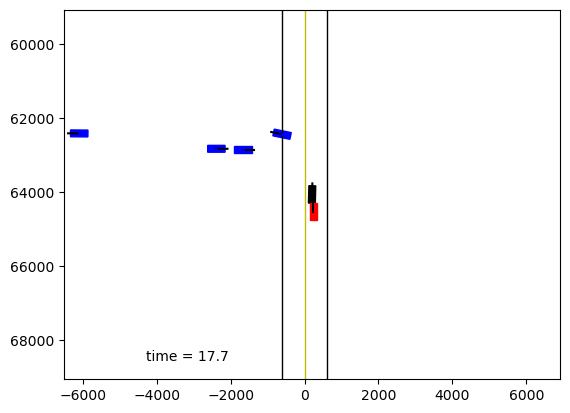

In [43]:
#animate_trajectory(original_states, rollout_states_idm, None, [0], params.k_closest_vehicles, params.k_closest_pedestrians, percent_to_animate=0.3, render_speedup=8.0, subsample=7, export_as_gif=False, export_as_mp4=False, filename="./Output/animation")

## OVM Animation

In [37]:
#animate_trajectory(original_states, rollout_states_ovm, None, [0], params.k_closest_vehicles, params.k_closest_pedestrians, percent_to_animate=1.0, render_speedup=8.0, subsample=7, export_as_gif=False, export_as_mp4=False, filename="./Output/animation")

# Fitting the parameters of IDM

#### First, we get out a dataset of subtrajectories

In [39]:
# Gather sub-trajectories for each demonstration, then stack them 
# into a single matrix of num_sub_trajectories x length_sub_trajectory x num_states
train_subs_per_demonstration = [get_sub_trajectories(demonstration_states, params) for demonstration_states in train_demonstration_states_line_frame]
train_sub_trajectories = np.vstack(train_subs_per_demonstration)

validation_subs_per_demonstration = [get_sub_trajectories(demonstration_states, params) for demonstration_states in validation_demonstration_states_line_frame]
validation_sub_trajectories = np.vstack(validation_subs_per_demonstration)

# Visualize a sub-trajectory
visualize_trajectory(train_sub_trajectories[20, :, :], k_closest_vehicles, k_closest_pedestrians)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

## Getting out a dataset of features based on what we've implemented here

#### We'll start by defining how to get features from the IDM and OVM models at each state 

In [ ]:
def get_IDM_features_from_state(state, params):
    """ 
        Get a vector of features associated with the IDM computation process from a particular state. 
    """
    # Flip the state so that the ego vehicle is facing up
    y, v_y, closest_vehicle_y, closest_vehicle_v_y, upwards = get_1d_state(state, params)

    # Actually run the model now that we've put it into 
    # a standard frame
    _, _, features = idm_standard_derivatives(y, v_y, closest_vehicle_y, closest_vehicle_v_y, params)

    return features

def get_OVM_features_from_state(state, params):
    """ 
        Get a vector of features associated with the IDM computation process from a particular state. 
    """
    # Flip the state so that the ego vehicle is facing up
    y, v_y, closest_vehicle_y, closest_vehicle_v_y, upwards = get_1d_state(state, params)

    # Actually run the model now that we've put it into 
    # a standard frame
    _, _, features = ovm_standard_derivatives(y, v_y, closest_vehicle_y, closest_vehicle_v_y, params)

    return features

# Ultimately we want an HDF5 file with keys X_train and X_validation,
# as well as an HDF5 file with keys Y_train and Y_validation. 
# okay so go through each demonstration, pull out the appropriate features. those features 
# have the information to align the brain data with them (can look back at how we paired training data for the 
# behavior cloning stuff to see how to do that). So then can collect the appropriate brain data.  
# essentially we'll call the get data from demonstrations (dealing with indexing and the IDs appropriately) 

#### Now, we'll define functions to get features from all of the demonstrations

In [ ]:
def get_features_from_demonstration(demonstration_states, features_from_state_fcn, params):
    return np.stack([features_from_state_fcn(demonstration_states[i, :], params) for i in range(demonstration_states.shape[0])])

def get_features_from_demonstrations(demonstrations, features_from_state_fcn, params):
    return np.vstack([get_features_from_demonstration(demonstration, features_from_state_fcn, params) for demonstration in demonstrations])

#### Average out the features and pull out the appropriate brain data for each demonstration

In [ ]:
def align_features_brain(state_matrix_line_frame, features, parser_dict, brain_dict, all_ids, params):
    # Pull out the appropriate part of the brain data for this demonstration
    id_index = round(state_matrix_line_frame[0, -1])
    # assert the last row of state_matrix_line_frame is all equal
    assert(np.all(state_matrix_line_frame[:, -1] == id_index))

    # Get the brain data matrix
    parser = parser_dict[all_ids[id_index]]
    brain_data = brain_dict[all_ids[id_index]]

    # Now, find the first and last TR we'd like to align with this
    raw_indices = np.rint(state_matrix_line_frame[:, -2]).astype(np.int32)
    first_index = raw_indices[0]
    last_index = raw_indices[-1]
    first_TR = raw_index_to_tr(parser, first_index)
    last_TR = raw_index_to_tr(parser, last_index)

    # Edge case where run has gone bast number of TRs
    last_TR = np.minimum(last_TR, brain_data.shape[0] - 1)

    averaged_features = np.zeros((last_TR - first_TR + 1, features.shape[1]))
    aligned_brain_data = np.zeros((last_TR - first_TR + 1, brain_data.shape[1]))

    # For now, we'll still include incomplete TRs.
    for i, TR in enumerate(range(first_TR, last_TR+1)):
        # Get the brain data for this TR
        aligned_brain_data[i, :] = brain_data[TR, :]

        chunk_start_index = tr_to_raw_index(parser, TR)
        chunk_end_index = tr_to_raw_index(parser, TR + 1)


        start_index_relative_to_demo = np.maximum(chunk_start_index - first_index, 0)
        end_index_relative_to_demo = np.minimum(chunk_end_index - first_index, state_matrix_line_frame.shape[0] - 1)
        # print("TR: ", TR)
        # print("first index: ", first_index)
        # print("last index: ", last_index)
        # print("chunk start: ", chunk_start_index)
        # print("chunk end: ", chunk_end_index)
        # print("end before min: ", chunk_end_index - first_index)
        # print("shape: ", state_matrix_line_frame.shape[0] - 1)
        # print("rel to demo: ", start_index_relative_to_demo, end_index_relative_to_demo)
        # print("averaging from {} to {}".format(start_index_relative_to_demo, end_index_relative_to_demo))
        averaged_features[i, :] = np.mean(features[start_index_relative_to_demo:end_index_relative_to_demo, :], axis=0)

    return averaged_features, aligned_brain_data    


In [ ]:
def get_averaged_aligned_features_from_demonstration(demonstration_states, features_from_state_fcn, parser_dict, brain_dict, all_ids, params):
    features = get_features_from_demonstration(demonstration_states, features_from_state_fcn, params)
    averaged_features, aligned_brain_data = align_features_brain(demonstration_states, features, parser_dict, brain_dict, all_ids, params)
    return averaged_features, aligned_brain_data

#### Load the appropriate parsers and brain data. 

In [ ]:
if False:
    # Load the parsers
    parser_filenames = [f"./Data/LogAndLabelData/{id}_positions.xml" for id in all_ids]
    parsers = load_log_data(parser_filenames)

    # Put the parsers in a dictionary mapping from run_id to parser
    parser_dict = {}
    for i in range(len(all_ids)):
        print("loading parser: ", all_ids[i])
        parser_dict[all_ids[i]] = parsers[i]

    # Load the brain data
    brain_filenames = [f"./Data/BrainData/{id}_combined data.npy" for id in all_ids]
    brain_data = load_brain_data(brain_filenames)

    # Put the brain data in a dictionary mapping from brain_id to brain data
    brain_data_dict = {}
    for i in range(len(all_ids)):
        brain_data_dict[all_ids[i]] = brain_data[i]

loading parser:  20210126SP_13-52-24
loading parser:  20210126SP_14-38-49
loading parser:  20210126SP_14-08-22
loading parser:  20210126SP_14-23-30


In [ ]:
#np.any(np.isnan(feat_brain_list_validation_idm[3][0]))

In [ ]:
#np.any(np.isnan(X_validation_idm))

In [ ]:
parsers[2].firstTRFrame + 96 * 2.0045 * 15

3255.4800000000005

In [ ]:
tr_to_raw_index(parsers[2], 96)


3256

In [ ]:
raw_index_to_tr(parsers[2], 3255)

95

In [ ]:
raw_index_to_tr(parsers[2], tr_to_raw_index(parsers[2], 96))

96

In [ ]:
# Test out getting the aligned features
averaged_features, aligned_brain_data = get_averaged_aligned_features_from_demonstration(validation_demonstration_states_line_frame[3], get_IDM_features_from_state, parser_dict, brain_data_dict, all_ids, params)

# check if averaged features are nan
print(np.any(np.isnan(averaged_features)))


False


In [ ]:
# Now, build the training set
feat_brain_list_train_idm = [ get_averaged_aligned_features_from_demonstration(demonstration, get_IDM_features_from_state, parser_dict, brain_data_dict, all_ids, params) for demonstration in train_demonstration_states_line_frame]
X_train_idm = np.vstack([feat_brain[0] for feat_brain in feat_brain_list_train_idm])
Y_train = np.vstack([feat_brain[1] for feat_brain in feat_brain_list_train_idm])

demonstration_lengths = [feat_brain[0].shape[0] for feat_brain in feat_brain_list_train_idm]
demonstration_offsets = np.cumsum(demonstration_lengths)
demonstration_offsets = np.insert(demonstration_offsets, 0, 0)
demonstration_offsets = demonstration_offsets[:-1]

# the brain data should match between, so just pull out X features for ovm
feat_brain_list_train_ovm = [ get_averaged_aligned_features_from_demonstration(demonstration, get_OVM_features_from_state, parser_dict, brain_data_dict, all_ids, params) for demonstration in train_demonstration_states_line_frame]
X_train_ovm = np.vstack([feat_brain[0] for feat_brain in feat_brain_list_train_ovm])

# Now, build the validation set
feat_brain_list_validation_idm = [ get_averaged_aligned_features_from_demonstration(demonstration, get_IDM_features_from_state, parser_dict, brain_data_dict, all_ids, params) for demonstration in validation_demonstration_states_line_frame]
X_validation_idm = np.vstack([feat_brain[0] for feat_brain in feat_brain_list_validation_idm])
Y_validation = np.vstack([feat_brain[1] for feat_brain in feat_brain_list_validation_idm])

# the brain data should match between, so just pull out X features for ovm
feat_brain_list_validation_ovm = [ get_averaged_aligned_features_from_demonstration(demonstration, get_OVM_features_from_state, parser_dict, brain_data_dict, all_ids, params) for demonstration in validation_demonstration_states_line_frame]
X_validation_ovm = np.vstack([feat_brain[0] for feat_brain in feat_brain_list_validation_ovm])

# Save to an HDF5 file
feature_name = "idm"
feature_dataset = {'X_train': X_train_idm, 'X_validation': X_validation_idm}
save_hdf5_dataset(f"./Data/RegressionDatasets/{feature_name}_features.h5", feature_dataset)

feature_name = "ovm"
feature_dataset = {'X_train': X_train_ovm, 'X_validation': X_validation_ovm}
save_hdf5_dataset(f"./Data/RegressionDatasets/{feature_name}_features.h5", feature_dataset)

brain_dataset = {'Y_train': Y_train, 'Y_validation': Y_validation}
save_hdf5_dataset(f"./Data/RegressionDatasets/aligned_brain_data.h5", brain_dataset)


# save the demonstration offsets
offsets_dataset = {'demonstration_offsets': demonstration_offsets}
save_hdf5_dataset("./Data/RegressionDatasets/demonstration_offsets.h5", offsets_dataset)

/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_18342/703097918.py:24: UserWarning: s < 0, crashed
  warnings.warn("s < 0, crashed")


Saving... Saved ./Data/RegressionDatasets/idm_features.h5
Saving... Saved ./Data/RegressionDatasets/ovm_features.h5
Saving... Saved ./Data/RegressionDatasets/aligned_brain_data.h5
Saving... Saved ./Data/RegressionDatasets/demonstration_offsets.h5


In [ ]:
# test loading the dataset
test = load_hdf5_array(f"./Data/RegressionDatasets/{feature_name}_features.h5", 'X_train')

In [ ]:
# check if any nan in X_train 
np.any(np.isnan(X_validation_idm))

False

In [ ]:
# Find nan index in X_validation_idm
nan_index = np.argwhere(np.isnan(X_validation_idm))
nan_index

array([], shape=(0, 2), dtype=int64)